# Notebook 4
## MODEL training and hyper parameter search

This notebooks trains the models SVM, KNN, DT and RF
- it normalizes the data to 0.0 mean and 1.0 sigma
- trains the models with the default values of scikit learn
- trains the models with the default values of scikit learn using PCA feature reduction
- Grid and random searches for best hyper parameters

It displays scores:
- F1 scores 
- Recall 
- Precision
- confusion matrices


<div>
<img src="pose_landmarks_index.png" width="400"/>
</div>

In [ ]:
!pip install mediapipe

In [19]:
import numpy as np
#import mediapipe as mp
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import json

from pathlib import Path

import pose_ml  as pml

In [2]:
#get features
features  = pml.FEATURES
feature_descriptions = pml.FEATURE_DESCRIPTIONS

# get the actions
actions = pml.ACTIONS
action_descriptions = pml.ACTION_DESCRIPTIONS

print("Features: ")
for key, feature in feature_descriptions.items():
    print(key, feature)
print("\nActions: ")
for key, action in action_descriptions.items():
    print(key, action)



Features: 
(0, 2) nose, left eye
(0, 5) nose, right eye
(0, 7) nose, left ear
(0, 8) nose, right ear
(0, 9) nose, left mouth
(0, 10) nose, right mouth
(0, 11) nose, left shoulder
(0, 12) nose, right shoulder
(2, 5) left eye, right eye
(2, 7) left eye, left ear
(5, 8) right eye, right ear
(7, 8) left ear, right ear
(7, 9) left ear, left mouth
(7, 11) left ear, left shoulder
(8, 10) right ear, right mouth
(8, 12) right ear, right shoulder
(9, 10) left mouth, right mouth
(9, 11) left mouth, left shoulder
(10, 12) right mouth, right shoulder
(11, 12) left shoulder, right shoulder

Actions: 
C MIDDEN
TL LINKS BOVEN
TR RECHTS BOVEN
BL LINKS ONDER
BR RECHTS ONDER


### settings

In [3]:
project_data = Path(r"./data")
graph_path = Path(r"./graphs")
model_path = Path(r"./models")
sns.set(style="whitegrid")
color = ["Blue", "Red", "Orange", "Green", "Grey"] 
sns.set_palette(color) 


In [4]:
def plot_cm(cm_dict, score_type, fig_name = "", size = (2,4)):
    
    plt.figure(figsize=( 16,  8))   
    for i, (title, cm) in enumerate(cm_dict.items()):
        plt.subplot(size[0], size[1], i + 1)  # Create subplot for each score
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix: '+title)

    plt.tight_layout()
    if fig_name:
        plt.savefig(str(graph_path)+r'/confusion_matrix_'+fig_name+'.png')
    plt.show()

In [5]:
def plot_scores(scores_dict, score_type, fig_name="", size = (2,4)):

    plt.figure(figsize=( 16,  8))   
    for i, (title, score) in enumerate(sorted(scores_dict.items())):
        plt.subplot(size[0], size[1], i + 1)  # Create subplot for each score
        
        df = pd.DataFrame({
            'Class': actions,
            score_type: score
        })
        sns.barplot(x='Class', y=score_type, data=df)
       # sns.bar(range(len(score)), score, tick_label=actions)  # Assuming score is a dict with 'scores' and 'actions'
        # plt.xlabel('Class')
        # plt.ylabel(score_type)
        plt.title(f'{score_type} by actions: {title}')
        plt.ylim(0.0, 1.0)
    if fig_name:
        plt.savefig(str(graph_path) +r'/'+score_type.replace(' ', '_')+'_'+fig_name+'.png')
    plt.tight_layout()
    plt.show()

In [6]:
def plot_scores_avg(scores_dict, score_type, fig_name = "" ):
    df = pd.DataFrame(scores_dict)
    df_melted = df.melt(var_name='Model', value_name='Score')
    mean_scores = df_melted.groupby('Model')['Score'].mean().sort_values(ascending=False)
    pal=sns.color_palette("light:b", as_cmap=True)
    pal = sns.color_palette("light:b_r")
    pal = "light:b_r"
    # Plotting using seaborn
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Model', y='Score', data=df_melted, capsize=.2, order=mean_scores.index, palette=pal)
    
    # Adding the text on the bars
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., 0.5, '{:1.2f}'.format(p.get_height()), 
                ha='center', va='bottom')

    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Average'+ score_type)
    plt.title('Average '+ score_type+ ' of Models')
    plt.tight_layout() # Adjust layout to not cut off labels
    if fig_name:
        plt.savefig(str(graph_path) +r'/'+score_type.replace(' ', '_')+'_'+fig_name+'.png')
    plt.show()






## read data and prepare for training

In [10]:
# load the data_set
_, samples, labels, _= pml.read_data(project_data)
print(f"Number of samples: {len(samples)} , and labels {len(labels)}")

Number of samples: 15000 , and labels 15000


In [12]:
df = pd.DataFrame(samples, columns = features)
df['action_id'] =  labels
df['action'] = df['action_id'].map({0: 'C', 1: 'TL', 2: 'TR', 3: 'BL', 4: 'BR'})
#pml.inspect_data(df)
for feature in features:
    #print(features_desc(feature))
    print (f"feature: {features.index(feature)}, mean { df[feature].mean():.5f},",
           f"std {df[feature].std(ddof=1):.5f}, {feature_descriptions[feature]}")

feature: 0, mean 0.04026, std 0.01000, nose, left eye
feature: 1, mean 0.03903, std 0.01009, nose, right eye
feature: 2, mean 0.04406, std 0.01771, nose, left ear
feature: 3, mean 0.04302, std 0.01732, nose, right ear
feature: 4, mean 0.04364, std 0.00851, nose, left mouth
feature: 5, mean 0.04404, std 0.00780, nose, right mouth
feature: 6, mean 0.22328, std 0.04783, nose, left shoulder
feature: 7, mean 0.23235, std 0.04743, nose, right shoulder
feature: 8, mean 0.03829, std 0.00716, left eye, right eye
feature: 9, mean 0.03011, std 0.00971, left eye, left ear
feature: 10, mean 0.03039, std 0.01037, right eye, right ear
feature: 11, mean 0.07369, std 0.01315, left ear, right ear
feature: 12, mean 0.06165, std 0.01729, left ear, left mouth
feature: 13, mean 0.22078, std 0.04160, left ear, left shoulder
feature: 14, mean 0.06020, std 0.01735, right ear, right mouth
feature: 15, mean 0.22979, std 0.03911, right ear, right shoulder
feature: 16, mean 0.02880, std 0.00584, left mouth, right 

# Model training Analysis

## First normalize the values to have 0.0 mean ans 1.0 sigma, and save this for inference in Notbook 5

In [13]:
feature_stats = pd.DataFrame({'mean': df[features].mean(), 'std':df[features].std(ddof=1)})
feature_stats.to_json( str(model_path / "feature_stats.json"))

for feature in features:
    df[feature] = (df[feature]-df[feature].mean())/df[feature].std(ddof=1)
    


In [14]:
print("Feature statistics")
print(feature_stats)


Feature statistics
              mean       std
(0, 2)    0.040256  0.010003
(0, 5)    0.039030  0.010094
(0, 7)    0.044056  0.017707
(0, 8)    0.043022  0.017324
(0, 9)    0.043643  0.008515
(0, 10)   0.044039  0.007796
(0, 11)   0.223275  0.047826
(0, 12)   0.232345  0.047433
(2, 5)    0.038287  0.007162
(2, 7)    0.030115  0.009709
(5, 8)    0.030392  0.010374
(7, 8)    0.073687  0.013152
(7, 9)    0.061654  0.017293
(7, 11)   0.220776  0.041596
(8, 10)   0.060203  0.017347
(8, 12)   0.229787  0.039111
(9, 10)   0.028796  0.005836
(9, 11)   0.180501  0.040372
(10, 12)  0.188974  0.040666
(11, 12)  0.207278  0.031399


# SVM, TREE, KNN, RF

In [15]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from joblib import dump, load

prepare trainingset by splitting 70-30%

In [16]:
X=df[features]
y=df[['action_id']]

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=3680, stratify=y)
assert any(x is None for x in X_test) == False
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

scores = {}
confusion_m={}
f1_scores = {}
precision_scores ={}
recall_scores ={}


## 1. Train all models with default settings - NO PCA


In [52]:
models = {"SVC - linear": SVC(kernel = 'linear'),
          "SVC - rbf": SVC(kernel = 'rbf'),
          "SVC - poly": SVC(kernel = 'poly'),
          "KNN": KNeighborsClassifier(),
          "DT": DecisionTreeClassifier(),
          "RF": RandomForestClassifier()
         }

for key, model in models.items():
    print("Starting model: ", model)

    scores[key]=model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    confusion_m[key] = confusion_matrix(y_test, y_pred)
    f1_scores[key] = f1_score(y_test, y_pred, average=None)
    precision_scores[key] = precision_score(y_test, y_pred, average = None)
    recall_scores[key]  = recall_score(y_test, y_pred, average = None)
    
    print('--') 


Starting model:  SVC(kernel='linear')
--
Starting model:  SVC()
--
Starting model:  SVC(kernel='poly')
--
Starting model:  KNeighborsClassifier()
--
Starting model:  DecisionTreeClassifier()
--
Starting model:  RandomForestClassifier()
--


In [81]:
#save these models for later use
for key, model in models.items():
    dump(model, str(model_path)+'/'+str(model).replace('(', '_').replace(')', '_')+'.joblib')

## 2. Train all models with default settings - with PCA


### Transform dataset to PCA
In notebook 3 it was calculated that 5 principle components are covering 95% of the variance

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA based on analysis that 5 components predict > 95%
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split the dataset (now reduced to 3 principal components
X_train,X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, random_state=3680, stratify=y)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


### Train all models now with PCA


In [54]:
models = {"SVC - PCA": SVC(kernel = 'linear',),
          "SVC - PCA - rbf": SVC(kernel = 'rbf'),
          "SVC - PCA - poly": SVC(kernel = 'poly'),
          "DT - PCA": DecisionTreeClassifier(),
          "KNN - PCA": KNeighborsClassifier(),
          "RF - PCA": RandomForestClassifier()
         }

for key, model in models.items():
    print("Starting model: ", model)

    scores[key]=model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    confusion_m[key] = confusion_matrix(y_test, y_pred)
    f1_scores[key] = f1_score(y_test, y_pred, average=None)
    precision_scores[key] = precision_score(y_test, y_pred, average = None)
    recall_scores[key]  = recall_score(y_test, y_pred, average = None)
    
    print('--') 

Starting model:  SVC(kernel='linear')
--
Starting model:  SVC()
--
Starting model:  SVC(kernel='poly')
--
Starting model:  DecisionTreeClassifier()
--
Starting model:  KNeighborsClassifier()
--
Starting model:  RandomForestClassifier()
--


### Save the models for use in notebook 5

In [84]:
for key, model in models.items():
    dump(model, str(model_path)+'/'+str(model).replace('(', '_').replace(')', '_PCA')+'.joblib')


### Plot all scores

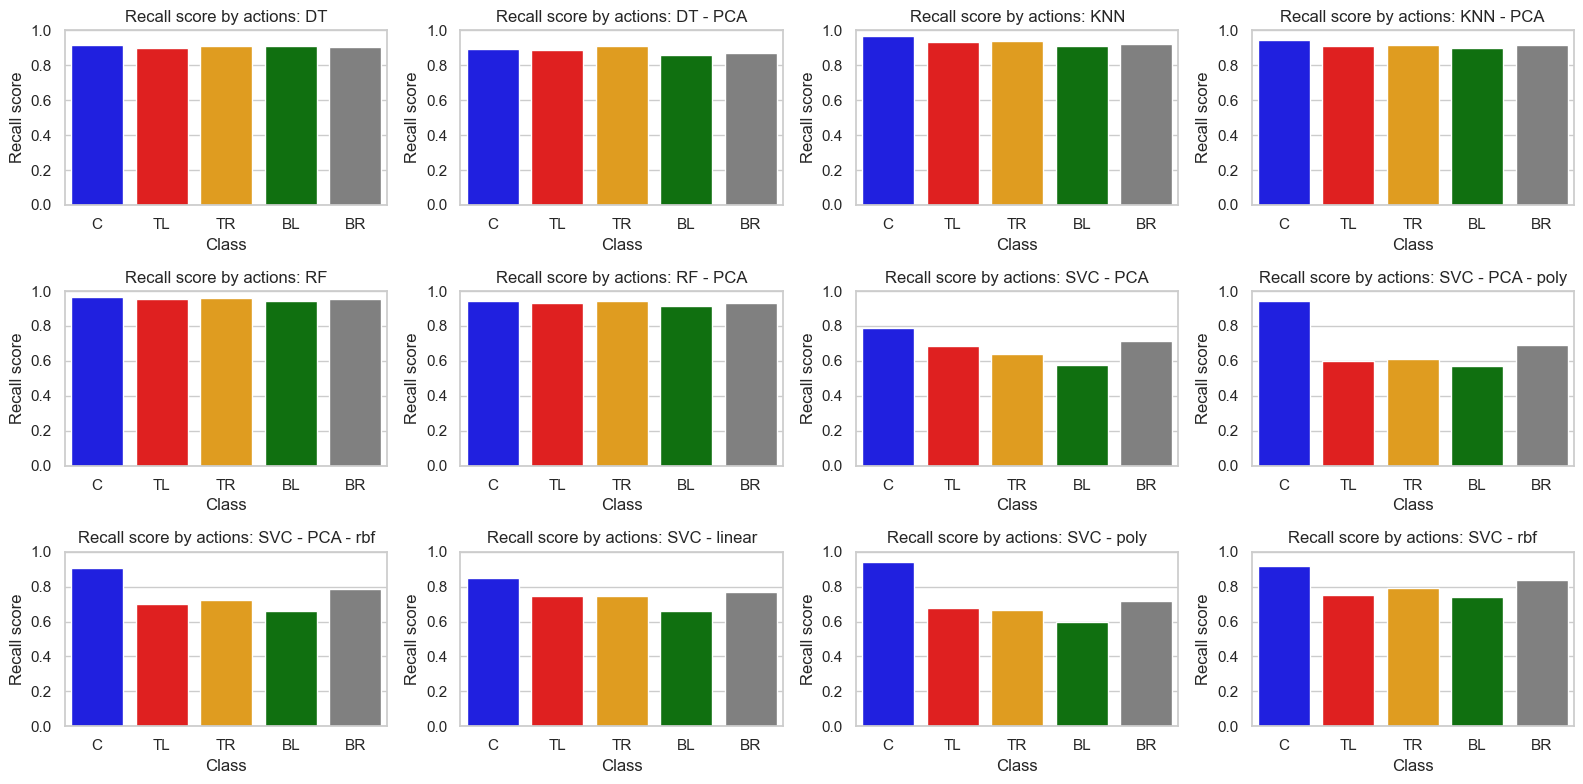

In [64]:

plot_scores(recall_scores,"Recall score", fig_name="all", size =(3,4))

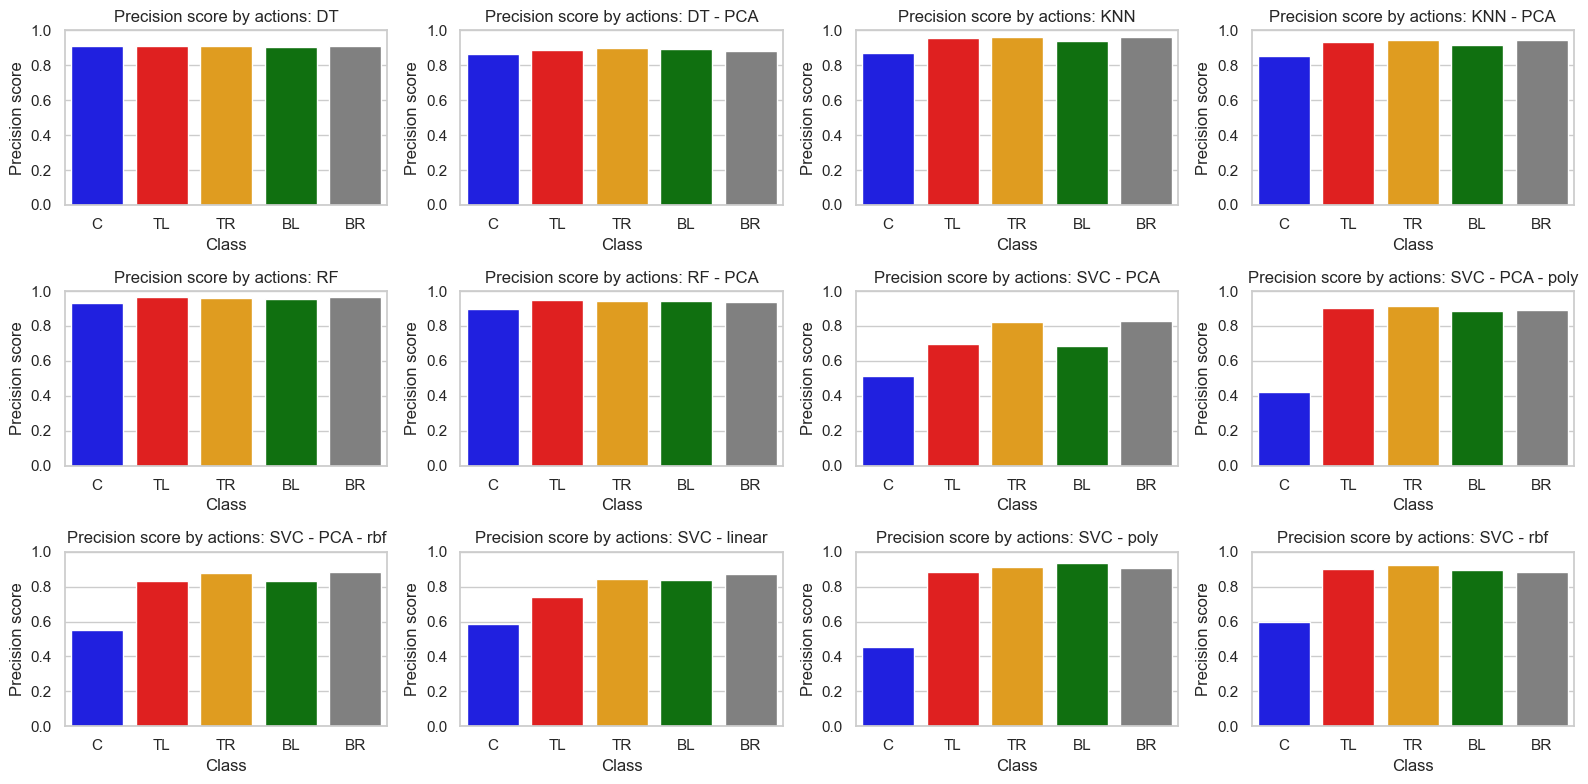

In [65]:
plot_scores(precision_scores,"Precision score", fig_name="all",size =(3,4))

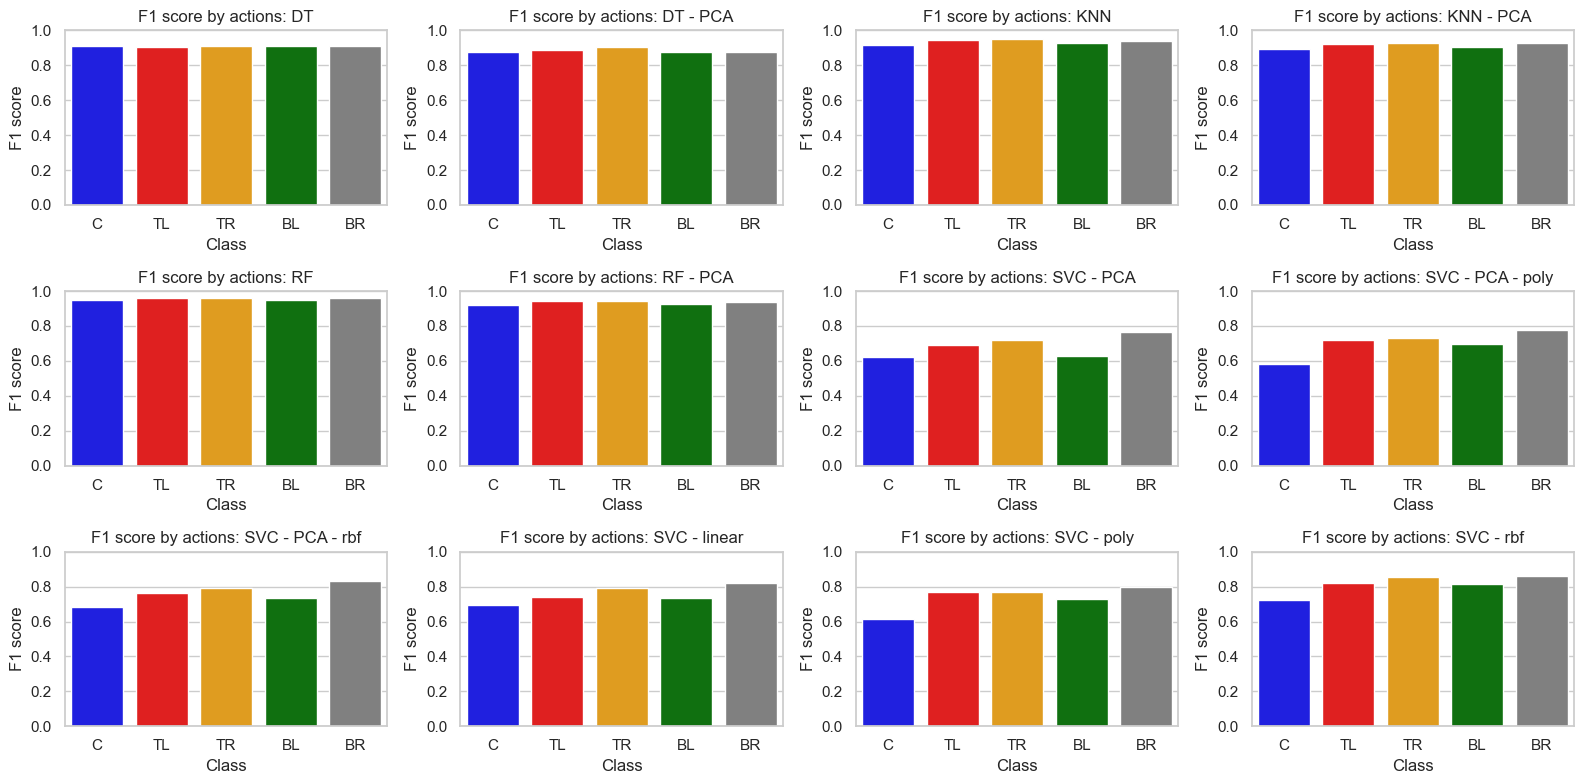

In [67]:
plot_scores(f1_scores,"F1 score",fig_name="all", size =(3,4))

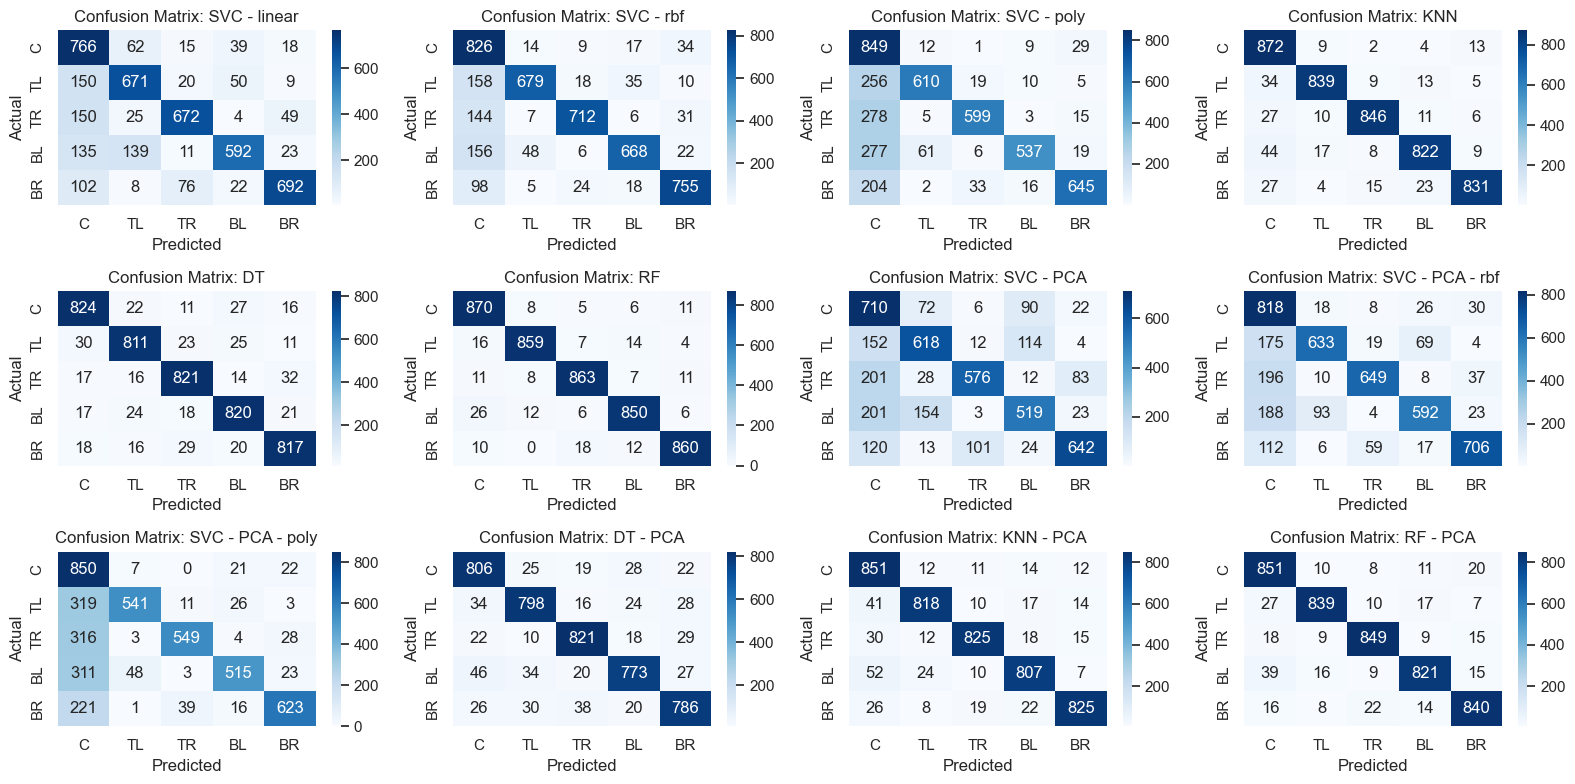

In [68]:
plot_cm(confusion_m,"Confusion Matrix", fig_name="all", size = (3,4))

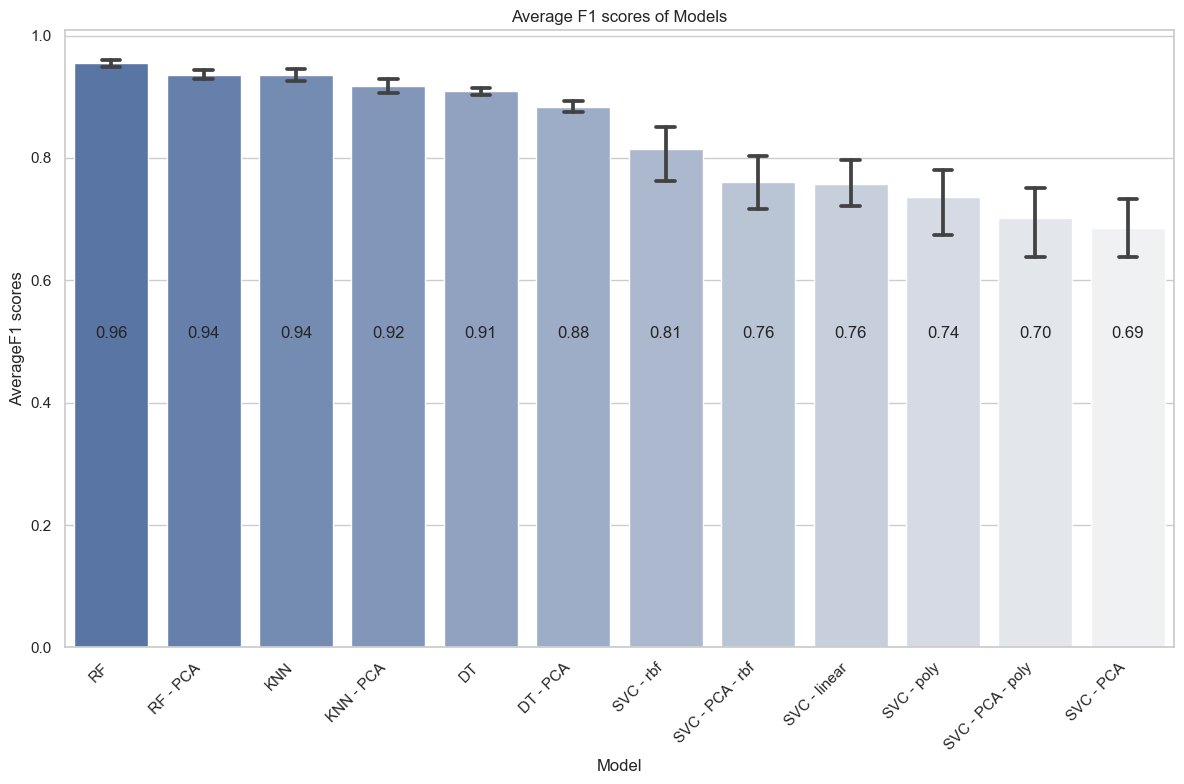

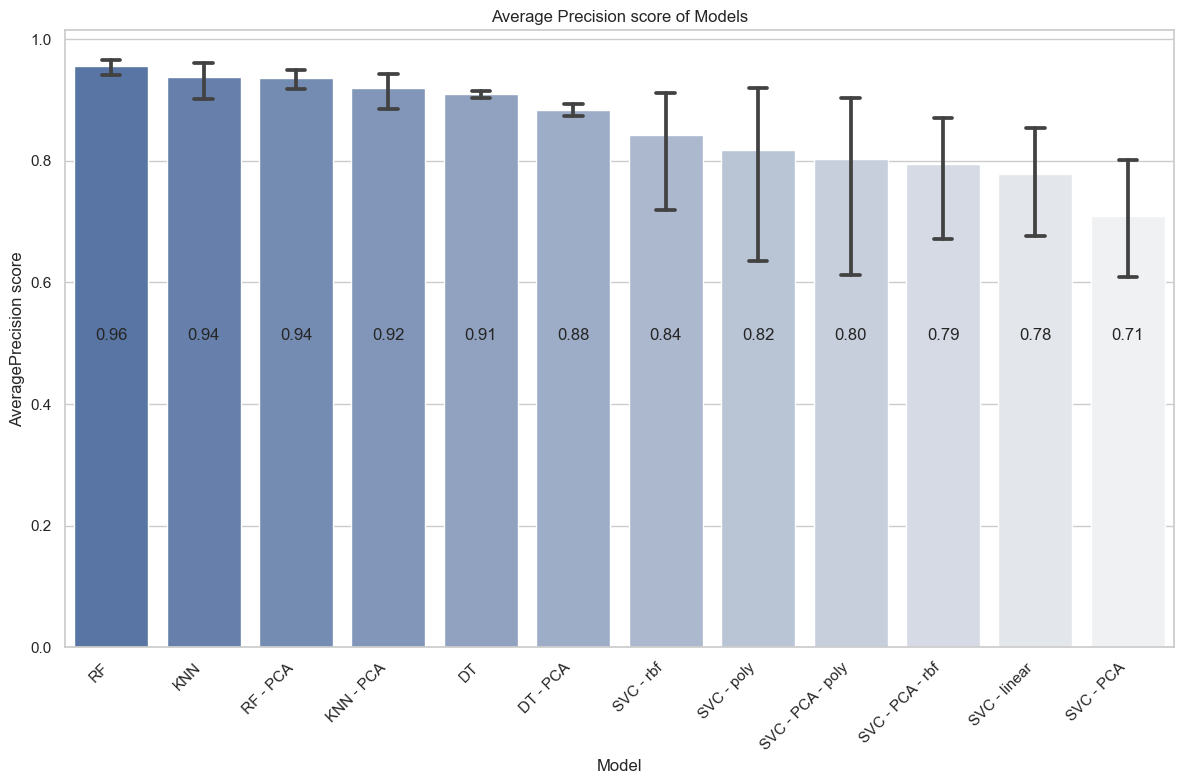

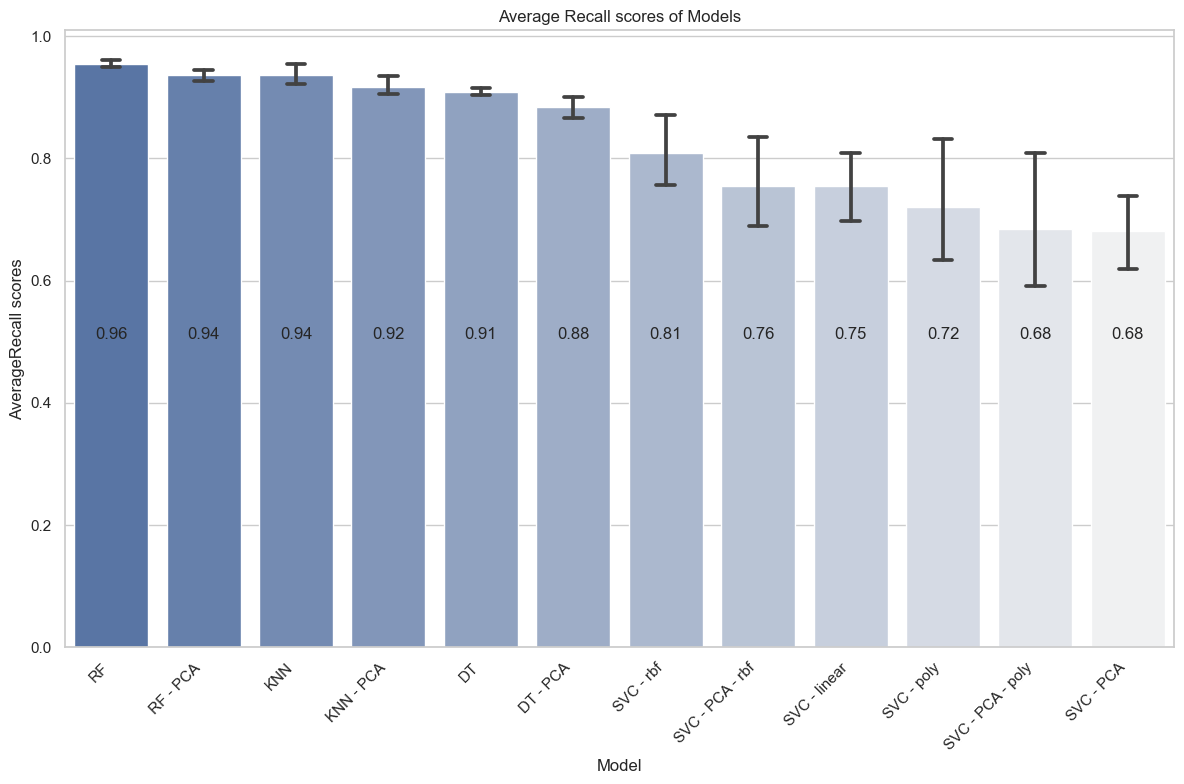

In [90]:
plot_scores_avg(f1_scores,"F1 scores","avg")
plot_scores_avg(precision_scores,"Precision score","avg")
plot_scores_avg(recall_scores,"Recall scores","avg")


# ------------------

# 3. Gridsearch SVM for hyper parameter 'C'

### NOTE: running below code might take long times. 
Alternativly skip the search and continue by loading the json files after the search cells.in de project directory. 
If performing the search and results need to be save change 
save = True

In [35]:
save = False

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

### reload the dataset

In [20]:
X=df[features]
y=df[['action_id']]

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=3680, stratify=y)
print(any(x is None for x in X_test))
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

results = []

False


### Linear kernel no PCA

### NOTE
This grid search takes enormous time and therefor is skipped afer 10^3. If running this you will see that the score is quite low ~.6 to .7 and not increasing Therefor it is assumed that this model is not suitable for this dataset.

In [ ]:
svc=SVC(kernel = 'linear')

# GridSearchCV
param_grid = {'C': [10**i for i in range(-2,3)]}
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose = 3)
grid_search.fit(X_train, y_train)

C_values = grid_search.cv_results_['param_C']
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Creating a DataFrame for easier plotting
results.append( pd.DataFrame({
    'C': C_values,
    'Mean Test Score': mean_test_scores,
    'kernel': 'linear no pca'
}))
if save: 
    results[-1].to_json(r"./gridsearch_svm_linear_no_pca.json")


In [22]:
# Best parameter and score
print("Best C parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best C parameter:  {'C': 100}
Best score:  0.7460952380952381


### RBF-kernel no PCA

In [ ]:
svc=SVC(kernel = 'rbf')
# GridSearchCV
param_grid = {'C': [10**i for i in range(-2,6)]}
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose = 3)
grid_search.fit(X_train, y_train)

C_values = grid_search.cv_results_['param_C']
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Creating a DataFrame for easier plotting
results.append( pd.DataFrame({
    'C': C_values,
    'Mean Test Score': mean_test_scores,
    'kernel': 'rbf no pca'
}))
if save: 
    results[-1].to_json(r"./gridsearch_svm_rbf_no_pca.json")


In [26]:
# Best parameter and score
print("Best C parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best C parameter:  {'C': 10000}
Best score:  0.9503809523809524


### Transform dataset to PCA
In notebook 3 it was calculated that 5 principle components are covering 95% of the variance

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Split the dataset (now reduced to 3 principal components)
X_train,X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, random_state=3680, stratify=y)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


### Linear kernel with PCA

### NOTE
This grid search takes enormous time and therefor is skipped afer 10^3. If running this you will see that the score is quite low ~.6 to .7 and not increasing Therefor it is assumed that this model is not suitable for this dataset.

In [ ]:
svc=SVC(kernel = 'linear')
# GridSearchCV
param_grid = {'C': [10**i for i in range(-2,3)]}
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose = 3)
grid_search.fit(X_train, y_train)

C_values = grid_search.cv_results_['param_C']
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Creating a DataFrame for easier plotting
results.append( pd.DataFrame({
    'C': C_values,
    'Mean Test Score': mean_test_scores,
    'kernel': 'linear with pca'
}))
if save: 
    results[-1].to_json(r"./gridsearch_svm_linear_with_pca.json")

In [31]:
# Best parameter and score
print("Best C parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best C parameter:  {'C': 0.01}
Best score:  0.6508571428571428


### RBF with PCA

In [ ]:
svc=SVC(kernel = 'rbf')
# GridSearchCV
param_grid = {'C': [10**i for i in range(-2,6)]}
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose = 3)
grid_search.fit(X_train, y_train)

C_values = grid_search.cv_results_['param_C']
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Creating a DataFrame for easier plotting
results.append( pd.DataFrame({
    'C': C_values,
    'Mean Test Score': mean_test_scores,
    'kernel': 'rbf with pca'
}))
if save: 
    results[-1].to_json(r"./gridsearch_svm_rbf_with_pca.json")
    


In [29]:
# Best parameter and score
print("Best C parameter: ", grid_search.best_params_)

print("Best score: ", grid_search.best_score_)

Best C parameter:  {'C': 100000}
Best score:  0.8001904761904763


Concatenate the results to a pandas data frame

## From here data can be loaded too

In [32]:
if save:
    df_total = pd.concat(results)
    df_total = pd.to_json("./gridsearch_SVM_all_models.json")
else:
    df_total = pd.read_json("./gridsearch_SVM_all_models.json")

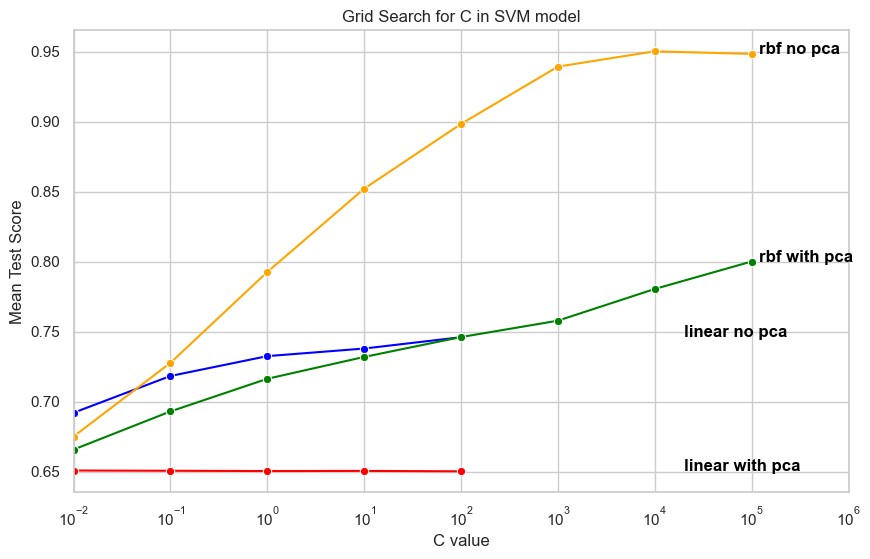

In [34]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_total, x='C', y='Mean Test Score', hue = 'kernel', marker = 'o', style = None, errorbar = None)

plt.xscale('log')  # Optional: Use if your C values span several orders of magnitude
plt.xlabel('C value')
plt.title('Grid Search for C in SVM model')
plt.xlim(10**-2, 10**6)
plt.legend().remove()
plt.grid(True)
# Annotate each line with its kernel name
shift_x = 0.2 * df_total['C'].max()
for kernel in df_total['kernel'].unique():
    df_kernel = df_total[df_total['kernel'] == kernel]
    # Get the last row in the dataframe for this kernel
    last_point = df_kernel.iloc[-1]
    plt.text(last_point['C']+ shift_x, last_point['Mean Test Score'], kernel, 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.savefig("./graphs/SVM_grid_search.png")
plt.show()

# random search for KNN

In [70]:
X=df[features]
y=df[['action_id']]

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=3680, stratify=y)
print(any(x is None for x in X_test))
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


False


In [71]:
# KNN model
knn = KNeighborsClassifier()

# Parameter distribution
param_dist = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],
    'leaf_size': np.arange(10, 50)
}

# Randomized search
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=1000, cv=5, verbose=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best Parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 1, 'metric': 'euclidean', 'leaf_size': 14, 'algorithm': 'brute'}
Best Score: 0.9579047619047618


In [76]:
# Best parameters and score
print("Best parameter settings found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print("Best Score:", random_search.best_score_)

Best parameter settings found:
weights: uniform
p: 2
n_neighbors: 1
metric: euclidean
leaf_size: 14
algorithm: brute
Best Score: 0.9579047619047618


Default:   
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,

In [ ]:
df = pd.DataFrame(random_search.cv_results_)
if save: 
    df.to_json("./grid_search_KNN_total.json")

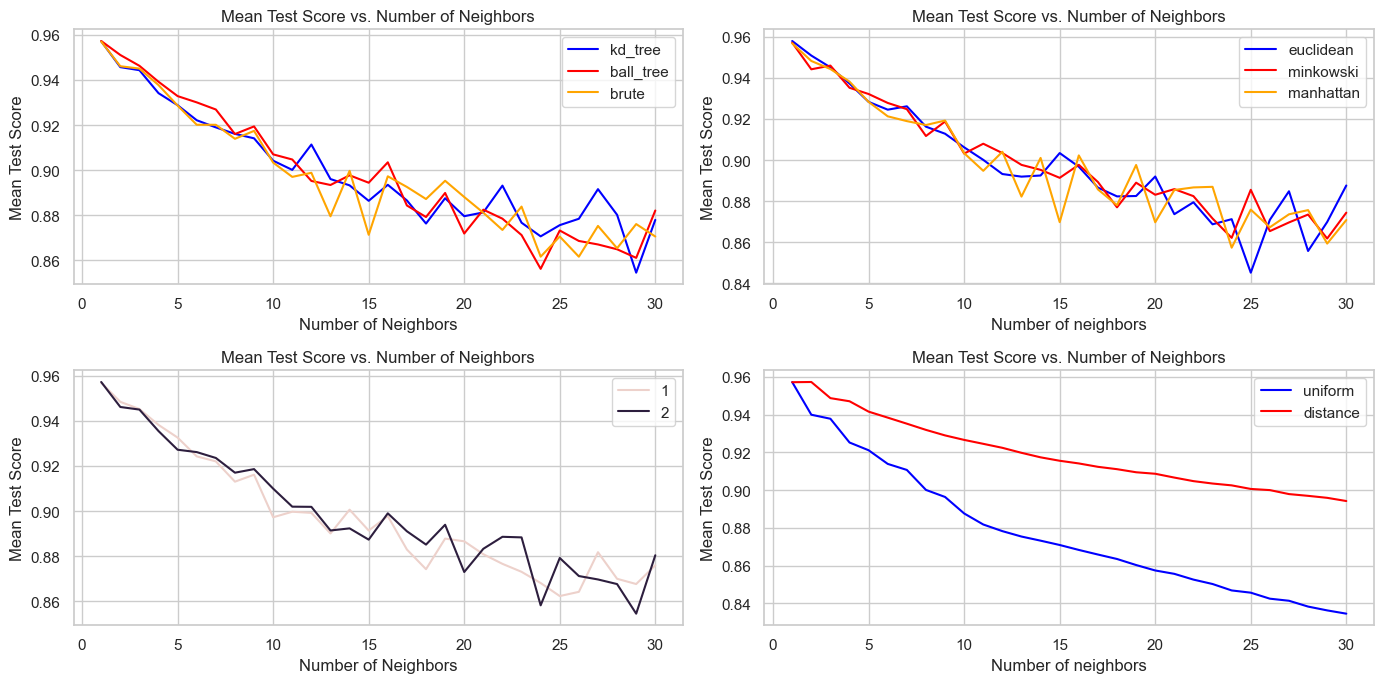

In [73]:

cv_results = random_search.cv_results_

# Extracting mean test scores
mean_test_scores = cv_results['mean_test_score']

# Extracting parameter values
n_neighbors = cv_results['param_n_neighbors']
weights = cv_results['param_weights']
algorithm =  cv_results['param_algorithm']#: ['ball_tree', 'kd_tree', 'brute'],
metric = cv_results['param_metric']#: ['euclidean', 'manhattan', 'minkowski'],
p = cv_results['param_p']#: [1, 2],
leaf_size = cv_results['param_leaf_size'] #: np.arange(10, 50)

# Plotting mean_test_scores against n_neighbors
plt.figure(figsize=(14, 7))

plt.subplot(2, 2, 1)
sns.lineplot(x=n_neighbors, y=mean_test_scores, hue = algorithm, errorbar = None)
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. Number of Neighbors')

plt.subplot(2, 2, 2)
sns.lineplot(x=n_neighbors, y=mean_test_scores, hue = metric, errorbar = None)
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. Number of Neighbors')

plt.subplot(2, 2, 3)
sns.lineplot(x=n_neighbors, y=mean_test_scores, hue = p, errorbar = None)
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. Number of Neighbors')

plt.subplot(2, 2, 4)
sns.lineplot(x=n_neighbors, y=mean_test_scores, hue = weights, errorbar = None)
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. Number of Neighbors')

# plt.subplot(3, 2, 2)
# sns.scatterplot(x=leaf_size, y=mean_test_scores)
# plt.xlabel('Number of leaves')
# plt.ylabel('Mean Test Score')
# plt.title('Mean Test Score vs. Number of leaves')

# # Since 'weights' is a categorical parameter, it's better to use a boxplot to visualize its effect
# plt.subplot(3, 2, 3)
# sns.boxplot(x=weights, y=mean_test_scores)
# plt.xlabel('Weights')
# plt.ylabel('Mean Test Score')
# plt.title('Mean Test Score vs. Weights')

# plt.subplot(3, 2, 4)
# sns.boxplot(x=weights, y=mean_test_scores)
# plt.xlabel('Weights')
# plt.ylabel('Mean Test Score')
# plt.title('Mean Test Score vs. Weights')

plt.tight_layout()
plt.show()

In [13]:
X=df[features]
y=df[['action_id']]

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=3680, stratify=y)
print(any(x is None for x in X_test))
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


False


In [16]:
# DT model
DT = DecisionTreeClassifier()

# Parameter distribution
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None] + list(np.arange(10, 50)),
    'min_impurity_decrease': np.linspace(0, 0.2, 50)
}
#['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'].

# Randomized search
random_search = RandomizedSearchCV(DT, param_distributions=param_dist, n_iter=10000, cv=5, verbose=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
Best Parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 17, 'criterion': 'entropy'}
Best Score: 0.8878095238095238


In [17]:
# Best parameters and score
print("Best parameter settings found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print("Best Score:", random_search.best_score_)

Best parameter settings found:
splitter: best
min_samples_split: 2
min_samples_leaf: 2
min_impurity_decrease: 0.0
max_leaf_nodes: None
max_features: None
max_depth: 17
criterion: entropy
Best Score: 0.8878095238095238


Default:
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,

In [18]:
df1 = pd.DataFrame(random_search.cv_results_)
if save: 
    df1.to_json("./grid_search_DT_total.json")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,...,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013608,0.007132,0.003125,0.006249,best,16,4,0.102041,28,sqrt,...,gini,"{'splitter': 'best', 'min_samples_split': 16, ...",0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,6552
1,0.012501,0.006251,0.000000,0.000000,random,19,9,0.142857,47,None,...,entropy,"{'splitter': 'random', 'min_samples_split': 19...",0.392857,0.200000,0.330476,0.346190,0.364762,0.326857,0.066742,4128
2,0.141307,0.017262,0.003126,0.006252,best,18,5,0.167347,17,None,...,entropy,"{'splitter': 'best', 'min_samples_split': 18, ...",0.356667,0.350000,0.357619,0.351429,0.348571,0.352857,0.003627,3470
3,0.047300,0.009884,0.003125,0.006251,best,15,19,0.085714,None,log2,...,entropy,"{'splitter': 'best', 'min_samples_split': 15, ...",0.434762,0.432381,0.502381,0.459048,0.420952,0.449905,0.029024,2223
4,0.006250,0.007655,0.003128,0.006257,random,14,19,0.089796,30,sqrt,...,gini,"{'splitter': 'random', 'min_samples_split': 14...",0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,6552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.029231,0.026272,0.031377,0.055425,random,12,5,0.187755,10,None,...,gini,"{'splitter': 'random', 'min_samples_split': 12...",0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,6552
9996,0.430367,0.194403,0.005748,0.010512,best,18,14,0.183673,20,None,...,entropy,"{'splitter': 'best', 'min_samples_split': 18, ...",0.356667,0.350000,0.357619,0.351429,0.348571,0.352857,0.003627,3470
9997,0.006256,0.007662,0.000000,0.000000,random,10,3,0.187755,32,sqrt,...,gini,"{'splitter': 'random', 'min_samples_split': 10...",0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,6552
9998,0.056927,0.075052,0.000000,0.000000,best,12,4,0.040816,35,log2,...,gini,"{'splitter': 'best', 'min_samples_split': 12, ...",0.371905,0.429048,0.357143,0.432381,0.402857,0.398667,0.030059,2778
